## Context 

Milan has a low emission zone called "area B" covering 90% of the city, that in coming years will progressively become more restrictive with certain categories of vehicles being banned from it. 

The mobility agency of Milan (AMAT) is working on analysing the environmental impact of the Low Emission Zones (LEZ) thanks to e.g. air quality reports. The challenge is to further contribute to this analysis, perform cross-domain analysis and make these reports available as a service and interoperable.

## Table of contents

* [Needed packages](#chapter1)
* [Importing data from CKAN](#chapter2)
     * [Metadata translation](#section_2_1)
     * [Datetime convertion](#section_2_2)
     * [Combining dataframe columns](#section_2_3)
     * [Columns filtering](#section_2_4)
* [Data visualization](#chapter3)

## Needed packages <a class="anchor" id="chapter1"></a>

We start by importing the Python libraries and packages available for performing our (geospatial) analysis. The role of every package will be explained later on this notebook.

Installing Python packages in Anaconda is a simple process that can be done through various methods, such as using the conda command, pip, or the Anaconda Navigator. For more details about these methods, please refer to [this tutorial.](https://www.tutorialspoint.com/how-do-i-install-python-packages-in-anaconda)

In [179]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

## Importing data from CKAN <a class="anchor" id="chapter2"></a>

The next step is to extract the data we need from our CKAN. 

Once we access our CKAN portal, we click on the "Organizations" tab. Since we are dealing with the municipality of Milan, we search for italian/milanese organizations. In our Example, we will focus on datasets available in the 'Commune di Milano' organization.

As we are interested in data related to emission reporting, we search for key words that match our needs. For example, the words 'air, 'quality', 'survey', '2023' (since we are interested in recent datasets), etc.

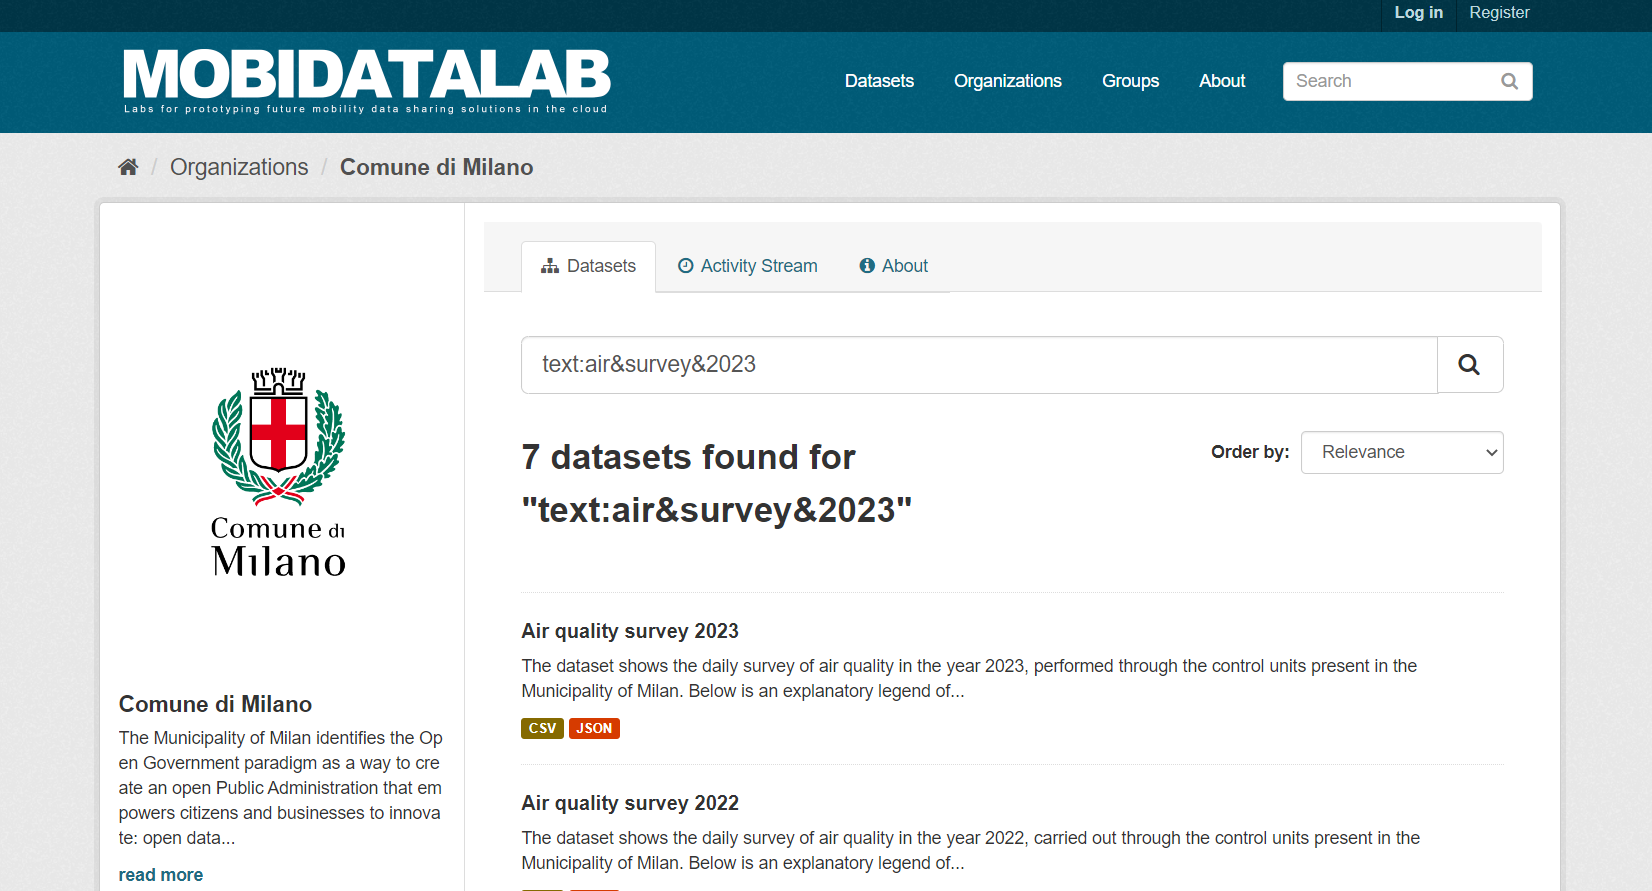

**Note the way the query is written: the keywords are preceded by 'text:' and are linked by '&'. This syntax should be remembered for all future keyword searches. Unless you know the exact name of the resource you are looking for, in which case, just enter it directly in the search bar.**

In our example, we select the first source, which contains two different datasets, both in diffrent formats: JSON and CSV.

When we click on the second datast (the JSON one), we get additional information about the resource, including the url that will allow us to access our data. We will then copy this URL, access it and store the information it contains using **Pandas**, a Python library for data analysis. It introduced two new types of objects for storing data that make analytical tasks easier and eliminate the need to switch tools: Series, which have a list-like structure, and DataFrames, which have a tabular structure (in our case, we will be using a dataframe).

In [138]:
# URL of the dataset
URL = 'https://dati.comune.milano.it/dataset/405ae1cd-0687-4449-baf2-6c9d993ed176/resource/781b1d03-5c4d-4c17-b10d-f9f74dbd7921/download/qaria_datoariagiornostazione_2023-04-22.json'

In [139]:
# Data extraction and storage in a DataFrame
try:
    df = pd.read_json(URL)
except Exception as e:
    print('Sorry, could not handle the json file. Error : ' + str(e))

In [137]:
# Presentation of the first five rows of the DataFrame
df.head()

,stazione_id,data,inquinante,valore
0,1,2023-04-28T00:00:00,NO2,NaN
1,2,2023-04-28T00:00:00,C6H6,0.5
2,2,2023-04-28T00:00:00,NO2,49.0
3,2,2023-04-28T00:00:00,O3,107.0
4,2,2023-04-28T00:00:00,PM10,20.0


### Metadata translation  <a class="anchor" id="section_2_1"></a>

Unless you are fluent in italian (in that case, lucky you!), you may need to translate some informations of the dataset in order to get a better understanding of the data.

In our case, we translated the name of the columns. For that, we used the Python library **deep translator**, which calls on Google translate and allows multi-language support as well as automatice language detection. 

In [140]:
# Get the list of all column names from headers
column_headers = list(df.columns.values)
for i in range(len(column_headers)):
    translated = GoogleTranslator(source='auto', target='en').translate(column_headers[i])
    df.rename(columns = {column_headers[i] :translated}, inplace = True)

In [141]:
df.head()

,station_id,data,pollutant,value
0,1,2023-04-28T00:00:00,NO2,NaN
1,2,2023-04-28T00:00:00,C6H6,0.5
2,2,2023-04-28T00:00:00,NO2,49.0
3,2,2023-04-28T00:00:00,O3,107.0
4,2,2023-04-28T00:00:00,PM10,20.0


We notice that the name column 'date' has not been well translated, so we correct that manually:

In [162]:
df.rename(columns = {'data':'date'}, inplace = True)
# check if the translation was successful
df.head()

,station_id,date,pollutant,value
0,1,2023-04-28,NO2,NaN
1,2,2023-04-28,C6H6,0.5
2,2,2023-04-28,NO2,49.0
3,2,2023-04-28,O3,107.0
4,2,2023-04-28,PM10,20.0


### Datetime convertion <a class="anchor" id="section_2_2"></a>

Before starting our analyse, we need to make sure that the column 'date' is in the right format. We take the first row as a sample:

In [158]:
print(type(df['date'][0]))

<class 'str'>


It is indicated that our dates are in string format, but they must be in 'timestamp' format otherwise we will not be able to display our diagrams. So we convert the column 'date':

In [161]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Check if the convertion was successful 
print(type(df['date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


 we wanted to get additional information about our data, like the name of the pollutants, the number of controle stations, and so on: 

In [152]:
# Additional informations about our dataset
print('Name of pollutants: ' + str(df['pollutant'].unique()))
print('Number of poulltants: ' + str(len(df['pollutant'].unique())))
print('ID of stations: ' + str(df['station_id'].unique()))
print('Number of stations: ' + str(len(df['station_id'].unique())))

Name of pollutants: ['NO2' 'C6H6' 'O3' 'PM10' 'PM25' 'SO2' 'CO_8h']
Number of poulltants: 7
ID of stations: [1 2 3 4 5 6 7 8]
Number of stations: 8


### Combining dataframe columns <a class="anchor" id="section_2_3"></a>

Now that our dataset is prepared, we can move on to the analyse part!

There are several possible analyses to do with the data set we have. In this notebook, we have chosen to display the amount of each pollutant by station and by month.

To proceed with the analysis, we first have to group the columns that interest us the most ('stattion_id, pollutant, date (or more precisely the month)) as follow:

In [169]:
df2 = df.groupby(['station_id', 'pollutant', df.date.dt.month])['value'].sum()
df2.head(8)

station_id  pollutant  date
1           NO2        1        0.0
                       2        0.0
                       3        0.0
                       4        0.0
2           C6H6       1       51.6
                       2       42.9
                       3       23.6
                       4       11.0
Name: value, dtype: float64

### Columns filtering <a class="anchor" id="section_2_4"></a>

We can also filter ou data depending on a specific month and station:

In [171]:
# Filter by single month
df3 = df[df['date'].dt.strftime('%Y-%m') == '2023-03']
df3 = df3[df3['station_id'] == 2]
df3.head(8)

,station_id,date,pollutant,value
460,2,2023-03-31,C6H6,0.5
461,2,2023-03-31,NO2,62.0
462,2,2023-03-31,O3,78.0
463,2,2023-03-31,PM10,20.0
464,2,2023-03-31,PM25,7.0
465,2,2023-03-31,SO2,2.5
487,2,2023-03-30,C6H6,0.5
488,2,2023-03-30,NO2,80.0


And then we proceed on calculating the quantity of each pollutatnt for the selected month:

In [175]:
df4 = df3.groupby(['station_id', 'pollutant'])['value'].sum()
df4.head(8)

station_id  pollutant
2           C6H6           23.6
            NO2          1431.0
            O3           1716.0
            PM10          671.0
            PM25          389.0
            SO2            86.0
Name: value, dtype: float64

## Data visualization <a class="anchor" id="chapter3"></a>

Finally, we display our dataset using the Python library **Matplotlib** which allows us to create static, animated, and interactive visualizations:

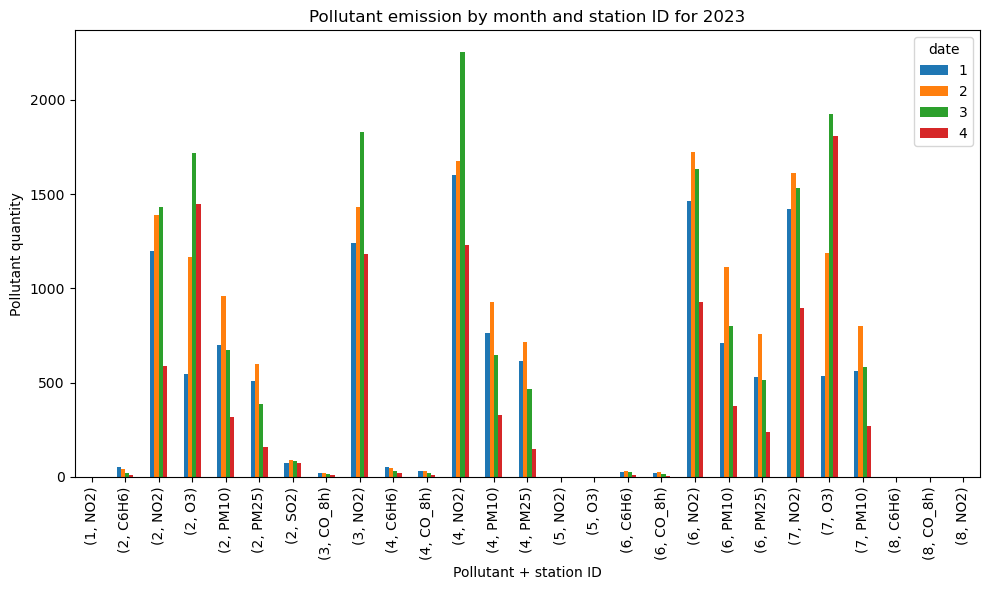

In [172]:
df2.unstack().plot(kind='bar', title='Pollutant emission by month and station ID for 2023',
               ylabel='Pollutant quantity', xlabel='Pollutant + station ID', figsize=(10, 6))
plt.show()

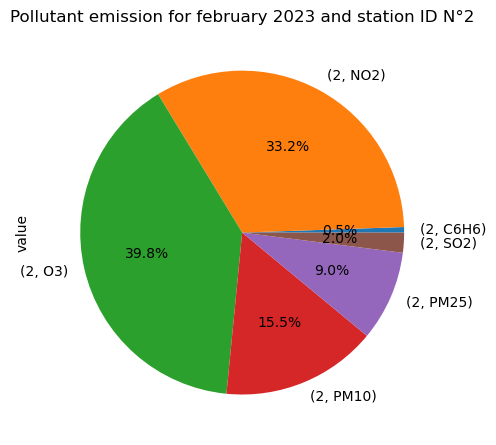

In [178]:
plot = df4.plot.pie(y='value', title='Pollutant emission for february 2023 and station ID N°2', figsize=(5,5),  autopct='%1.1f%%', textprops={'fontsize':10})

#### What’s Next?


You are now familiar with the concepts of Pandas DataFrames and Matplotlib, you can use them to further explore the datasets in our CKAN. Have fun!